Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv', 
                 parse_dates=['created'], 
                 index_col='created')
# assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
df.head()

,bathrooms,bedrooms,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
created,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-06-24 07:54:24,1.5,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-06-12 12:19:27,1.0,2,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-17 03:26:41,1.0,1,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-18 02:22:02,1.0,1,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016-04-28 01:32:41,1.0,4,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48817 entries, 2016-06-24 07:54:24 to 2016-04-12 02:48:07
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   description           47392 non-null  object 
 3   display_address       48684 non-null  object 
 4   latitude              48817 non-null  float64
 5   longitude             48817 non-null  float64
 6   price                 48817 non-null  int64  
 7   street_address        48807 non-null  object 
 8   interest_level        48817 non-null  object 
 9   elevator              48817 non-null  int64  
 10  cats_allowed          48817 non-null  int64  
 11  hardwood_floors       48817 non-null  int64  
 12  dogs_allowed          48817 non-null  int64  
 13  doorman               48817 non-null  int64  
 14  dishwasher            48817 non-nul

FEATURE ENGINEERING

In [5]:
#total number of rooms 
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['total_rooms']

created
2016-06-24 07:54:24    4.5
2016-06-12 12:19:27    3.0
2016-04-17 03:26:41    2.0
2016-04-18 02:22:02    2.0
2016-04-28 01:32:41    5.0
                      ... 
2016-06-02 05:41:05    3.0
2016-04-04 18:22:34    2.0
2016-04-16 02:13:40    2.0
2016-04-08 02:13:33    1.0
2016-04-12 02:48:07    3.0
Name: total_rooms, Length: 48817, dtype: float64

In [6]:
# allowed pets 

df['pets_allowed'] = df['cats_allowed'] + df['dogs_allowed']
df['pets_allowed']

created
2016-06-24 07:54:24    0
2016-06-12 12:19:27    2
2016-04-17 03:26:41    0
2016-04-18 02:22:02    0
2016-04-28 01:32:41    0
                      ..
2016-06-02 05:41:05    0
2016-04-04 18:22:34    2
2016-04-16 02:13:40    2
2016-04-08 02:13:33    2
2016-04-12 02:48:07    0
Name: pets_allowed, Length: 48817, dtype: int64

In [7]:
# converting interest level to numerical data 

# changing low to 0, medium to 1 and high to 2
df['interest_level'] = df['interest_level'].replace({'low':0 , 'medium':1, 'high':2})

print(df['interest_level'].dtype)
df['interest_level'].value_counts()

int64


0    33946
1    11181
2     3690
Name: interest_level, dtype: int64

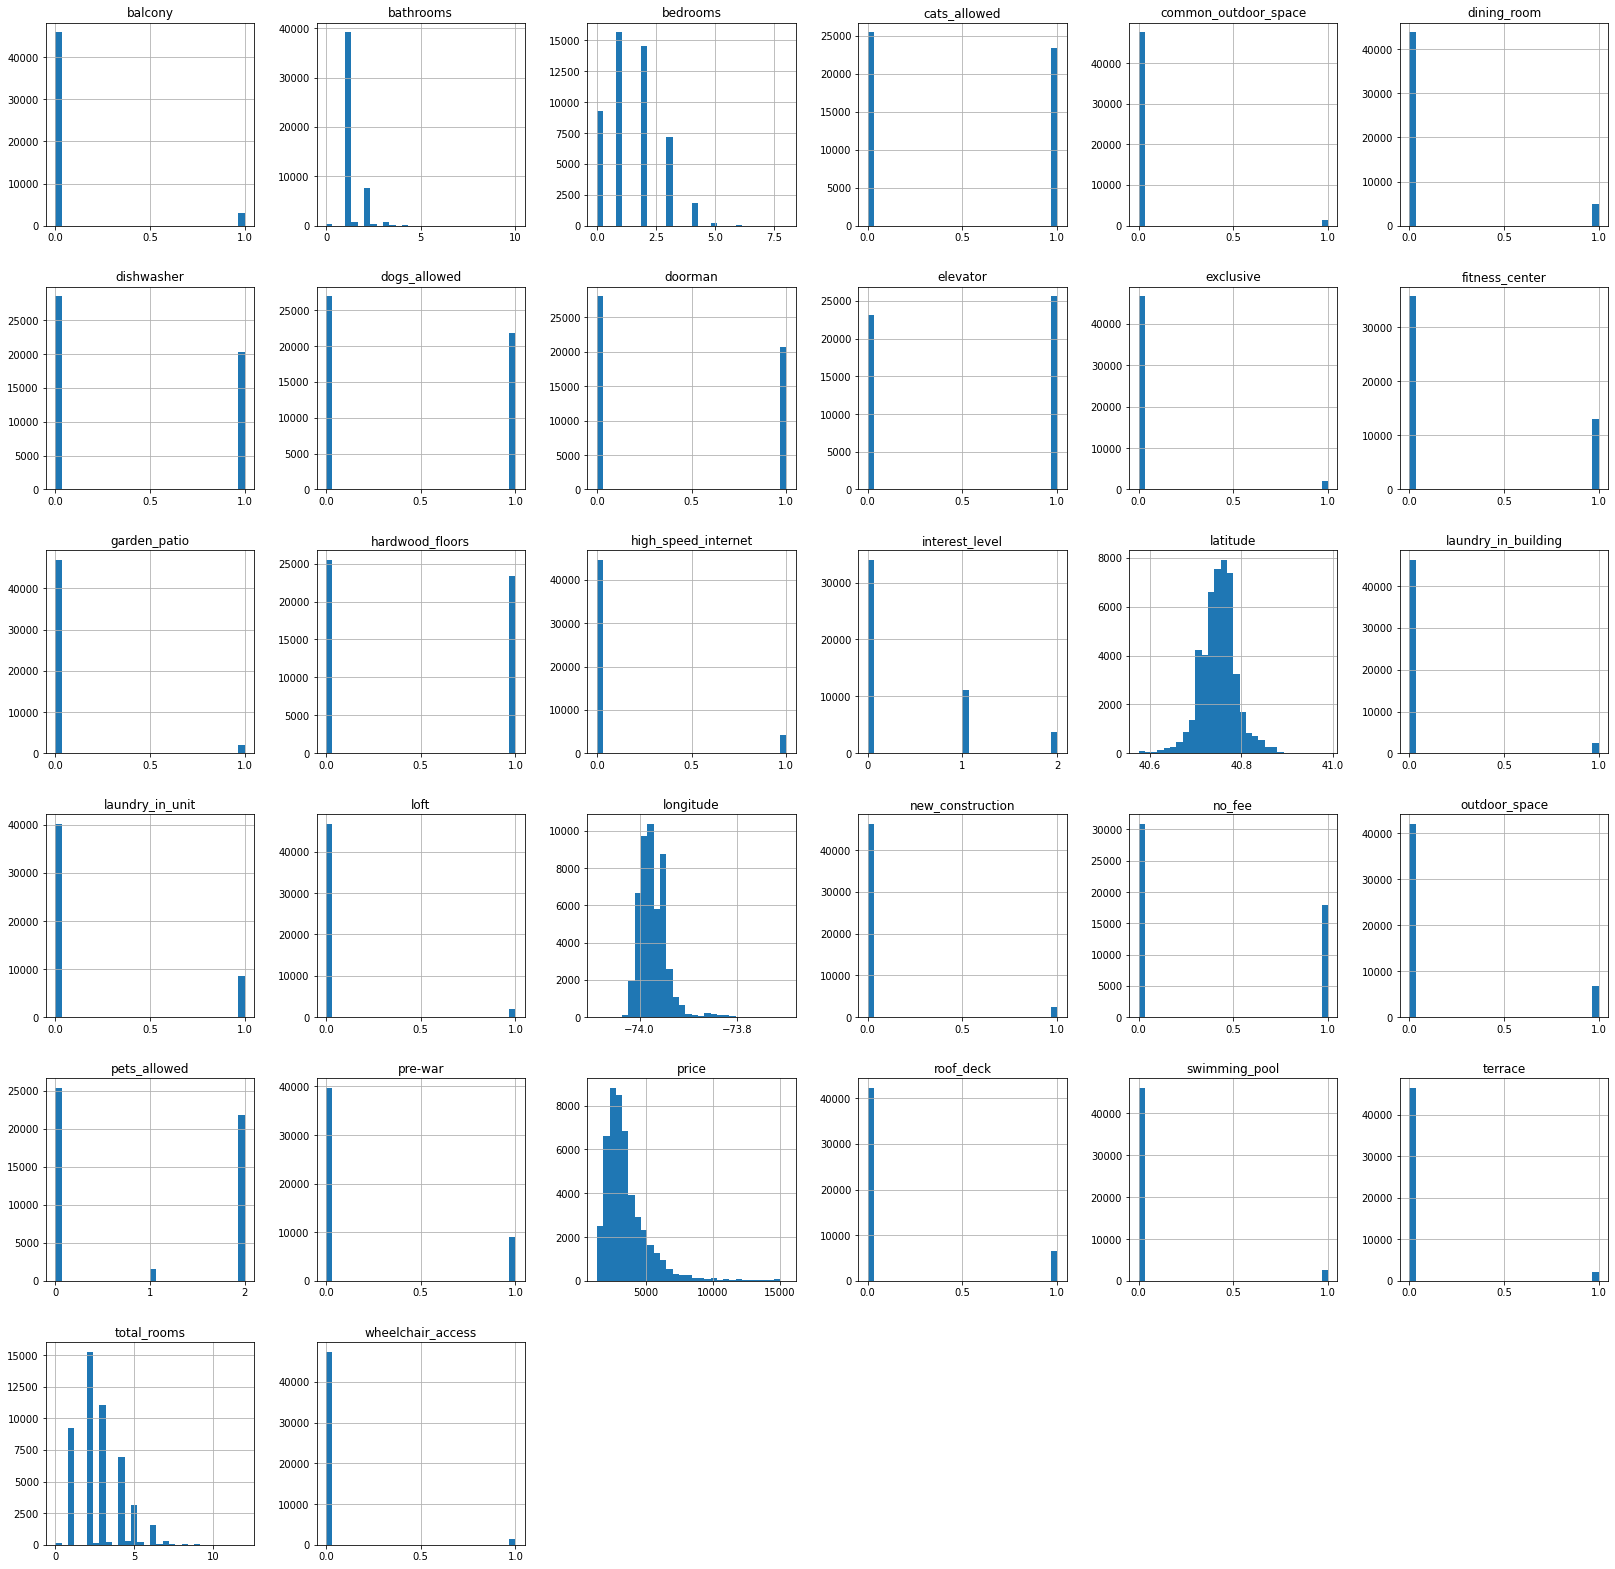

In [8]:
import matplotlib.pyplot as plt
df.hist(bins=30, figsize=(28,28))
plt.style.use('fivethirtyeight')
plt.show()

In [9]:
# correlation matrix 
corr_matrix = df.corr()
corr_matrix['price'].sort_values(ascending=False)


price                   1.000000
bathrooms               0.687296
total_rooms             0.649097
bedrooms                0.535503
doorman                 0.276215
laundry_in_unit         0.271195
dining_room             0.242911
fitness_center          0.228775
dishwasher              0.223899
elevator                0.207169
terrace                 0.145973
outdoor_space           0.142146
balcony                 0.139140
swimming_pool           0.134513
no_fee                  0.132240
roof_deck               0.122929
garden_patio            0.103672
hardwood_floors         0.101503
high_speed_internet     0.090269
wheelchair_access       0.072517
new_construction        0.071431
dogs_allowed            0.060401
pets_allowed            0.056815
cats_allowed            0.051453
common_outdoor_space    0.011517
loft                    0.007100
exclusive              -0.013251
laundry_in_building    -0.019417
pre-war                -0.029122
latitude               -0.036286
interest_l

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


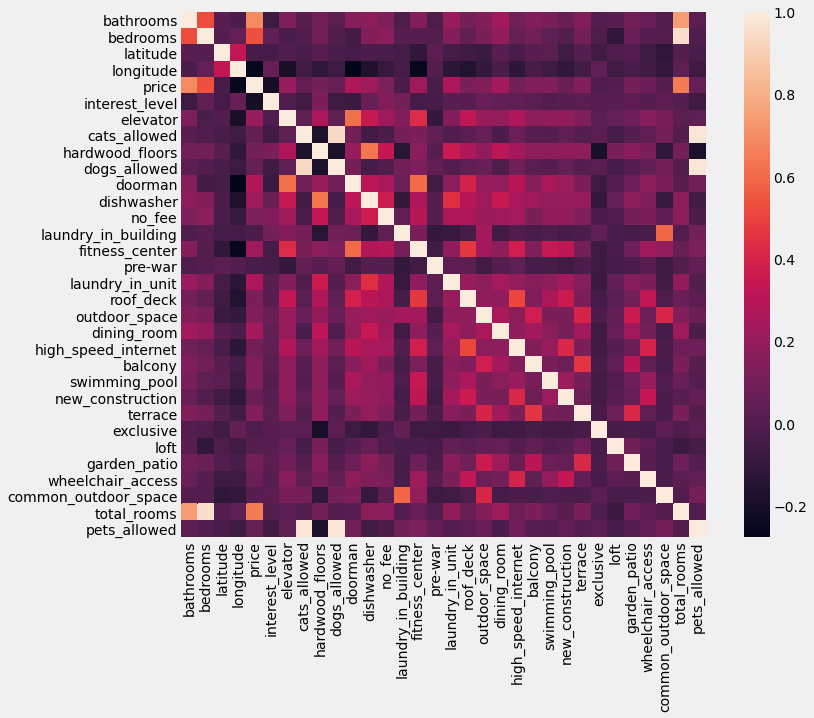

In [10]:
# heat map for correlation matrix 
import seaborn as sns
plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix,vmax=1, square=True)
plt.show()

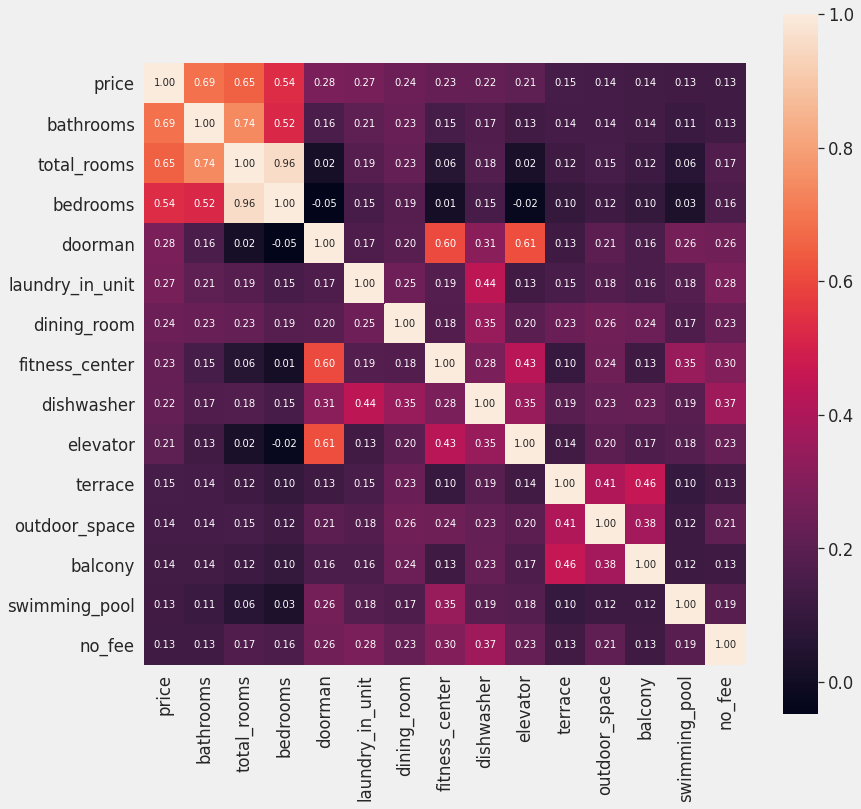

In [11]:
# top 15 features 
k=15
plt.figure(figsize=(12,12))
cols = corr_matrix.nlargest(k,'price').index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

Splitting the data 

In [12]:
# considering all the numerical values 
X = df.select_dtypes(exclude='object').drop('price', axis=1)
y = df['price']

In [13]:
# date created ranges from April to June. We will make month of June as our test set 
# now we split the dataset in train and test 

cutoff = '2016-06-01'

# applying the filter 
filt = X.index < cutoff
X_train, y_train = X.loc[filt], y.loc[filt]
X_test, y_test = X.loc[~filt], y.loc[~filt]

In [14]:
# baseline guess
def baseline_predict(X=None):
  return y_train.mean()

baseline_predict()

3575.604007034292

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

baseline_mae = mean_absolute_error(y_train, [y_train.mean()]*len(y_train))
baseline_rmse = mean_squared_error(y_train, [y_train.mean()]*len(y_train), squared=False)
baseline_rsquare = r2_score(y_train, [y_train.mean()]*len(y_train))

print('Baseline MAE:', baseline_mae)
print('Baseline RMSE:', baseline_rmse)
print('Baseline r2:', baseline_rsquare)

Baseline MAE: 1201.8811133682555
Baseline RMSE: 1762.1090255404863
Baseline r2: 0.0


In [16]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train);

In [17]:
y_pred = lin_reg.predict(X_train)
y_pred

array([2204.39955479, 2546.39955479, 4019.39955479, ..., 3622.60011632,
       3331.17824132, 2618.83705479])

In [18]:
# Checking our metrics for the TRAINING DATA
model_mae = mean_absolute_error(y_train, y_pred)
model_rmse = mean_squared_error(y_train, y_pred, squared=False)
model_r2 = r2_score(y_train, y_pred)

print('Model MAE (training data):', model_mae)
print('Model RMSE (training data):', model_rmse)
print('Model R^2 (training data):', model_r2)

Model MAE (training data): 673.354528478597
Model RMSE (training data): 1062.1728280599175
Model R^2 (training data): 0.6366502854408775


In [19]:
# Checking our metrics for the VALIDATION DATA
y_pred = lin_reg.predict(X_test)

model_mae = mean_absolute_error(y_test, y_pred)
model_rmse = mean_squared_error(y_test, y_pred, squared=False)
model_r2 = r2_score(y_test, y_pred)

print('Model MAE (validation data):', model_mae)
print('Model RMSE (validation data):', model_rmse)
print('Model R^2 (validation data):', model_r2)

Model MAE (validation data): 676.9394980285982
Model RMSE (validation data): 1047.2782322875585
Model R^2 (validation data): 0.6471093337848475


In [ ]:
# trying polynomial features in training data set
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

poly_reg = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
poly_reg.fit(X_train,y_train);

y_pred = poly_reg.predict(X_train)

model_mae = mean_absolute_error(y_train, y_pred)
model_rmse = mean_squared_error(y_train, y_pred, squared=False)
model_r2 = r2_score(y_train, y_pred)

print('Model MAE (training data):', model_mae)
print('Model RMSE (training data):', model_rmse)
print('Model R^2 (training data):', model_r2)

In [ ]:
# trying polynomial features in training test data set
y_pred = poly_reg.predict(X_test)

model_mae = mean_absolute_error(y_test, y_pred)
model_rmse = mean_squared_error(y_test, y_pred, squared=False)
model_r2 = r2_score(y_test, y_pred)

print('Model MAE (training data):', model_mae)
print('Model RMSE (training data):', model_rmse)
print('Model R^2 (training data):', model_r2)